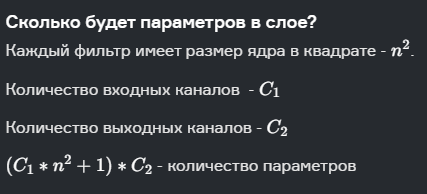

In [1]:
"""
Напишите функцию для подсчета количества параметров в сверточном слое. 
Ваша функция должна принимать на вход количество входных каналов, 
количество выходных каналов, размер ядра и стоит ли делать обучаемый сдвиг. 
Сделайте для нее такую сигнатуру: def count_parameters_conv(in_channels: int, out_channels: int, kernel_size: int, bias: bool):
"""

def count_parameters_conv(in_channels: int, out_channels: int, kernel_size: int, bias: bool):
    return (in_channels*kernel_size**2 + bias)*out_channels

In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
from IPython.display import clear_output
from PIL import Image
from matplotlib import cm
from time import perf_counter
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm

warnings.filterwarnings('ignore')

plt.rc('font', size=30)

In [3]:
mnist_train = MNIST(
    "../datasets/mnist",
    train=True,
    download=True,
    transform=T.ToTensor()
)

In [4]:
mnist_valid = MNIST(
    "../datasets/mnist",
    train=False,
    download=True,
    transform=T.ToTensor()
)

In [5]:
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
valid_loader = DataLoader(mnist_valid, batch_size=64, shuffle=False)

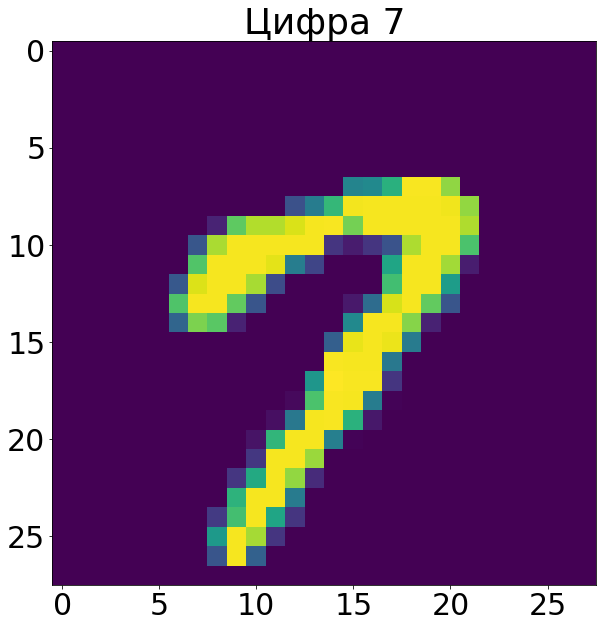

In [6]:
plt.figure(figsize=(10, 10))
plt.title(f'Цифра {mnist_train[15][1]}')
plt.imshow(mnist_train[15][0][0])

plt.show()

In [23]:
def train(model: nn.Module) -> float:
    model.train()

    train_loss = 0

    for x, y in tqdm(train_loader, desc='Train'):
        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)
    
    return train_loss

In [24]:
@torch.inference_mode()
def evaluate(model: nn.Module, loader: DataLoader):
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [25]:
def plot_stats(
    train_loss,
    valid_loss,
    valid_accuracy,
    title
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(valid_accuracy)
    plt.grid()

    plt.show()

In [29]:
def create_mlp_model() -> nn.Module:
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    )

first_model = create_mlp_model()

optimizer = torch.optim.Adam(first_model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

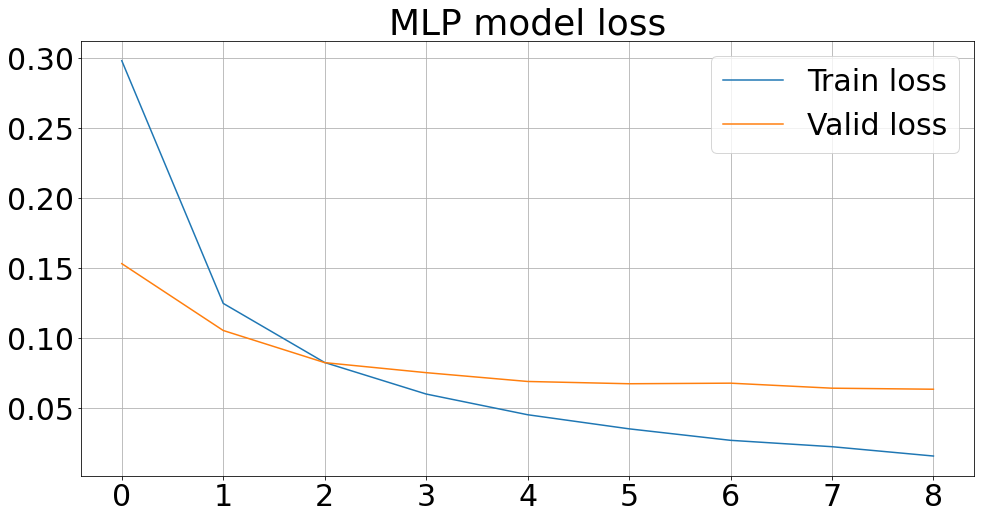

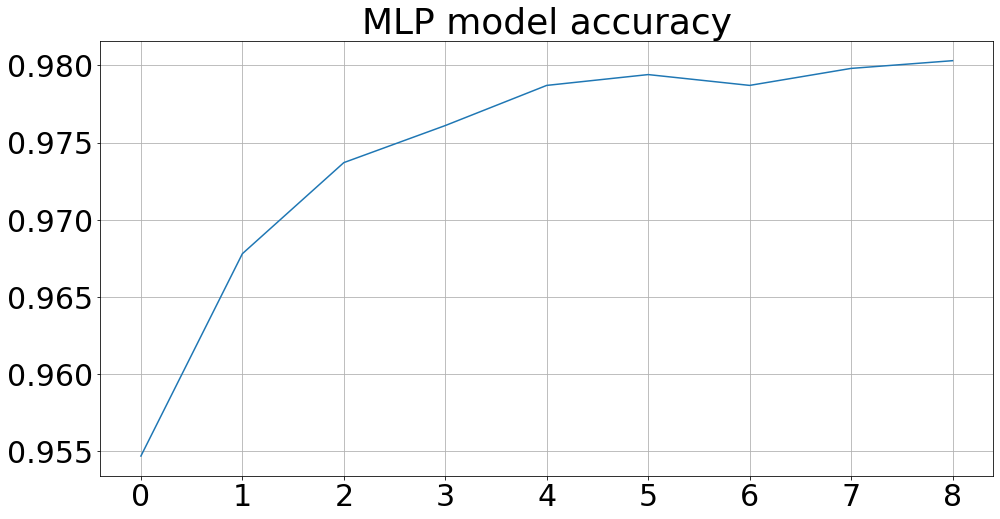

Total training and evaluation time 78.30548


In [30]:
num_epochs = 100
treshhold = 0.98

train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

start = perf_counter()

for epoch in range(num_epochs):
    train_loss = train(first_model)

    valid_loss, valid_accuracy = evaluate(first_model, valid_loader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)
    
    clear_output()

    plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'MLP model')
    
    if treshhold <= valid_accuracy:
        break
    
print(f'Total training and evaluation time {perf_counter() - start:.5f}')

In [18]:
valid_accuracy_history

In [19]:
torch.save(first_model.state_dict(), "checkpoint.pth")

In [25]:
"""
Обучите полносвязную нейронную сеть для классификации на датасете MNIST. 
Добейтесь качества в 98% на тестовой выборке.

Можете использовать уже написанные ранее функции train и evaluate.

Чтобы мы могли проверить вашу модель, напишите функцию, которая создает вашу модель и возвращает объект, 
назовите функцию create_mlp_model, без аргументов. 
Вам понадобится сохранить веса вашей модели и сдать их в тестировщик, для этого воспользуйтесь методами torch.save и state_dict.
"""



In [26]:
torch.save(create_mpl_model().state_dict(), "checkpoint.pth")

In [31]:
def create_conv_model():
    
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5), # 28 28 = 24 24
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2), # 24 24 = 12 12
        
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3), # 12 12 = 10 10 
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2), # 10 10 = 5 5
        
        nn.Flatten(),
        
        nn.Linear(64*5*5, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

second_model = create_conv_model()

optimizer = torch.optim.Adam(second_model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

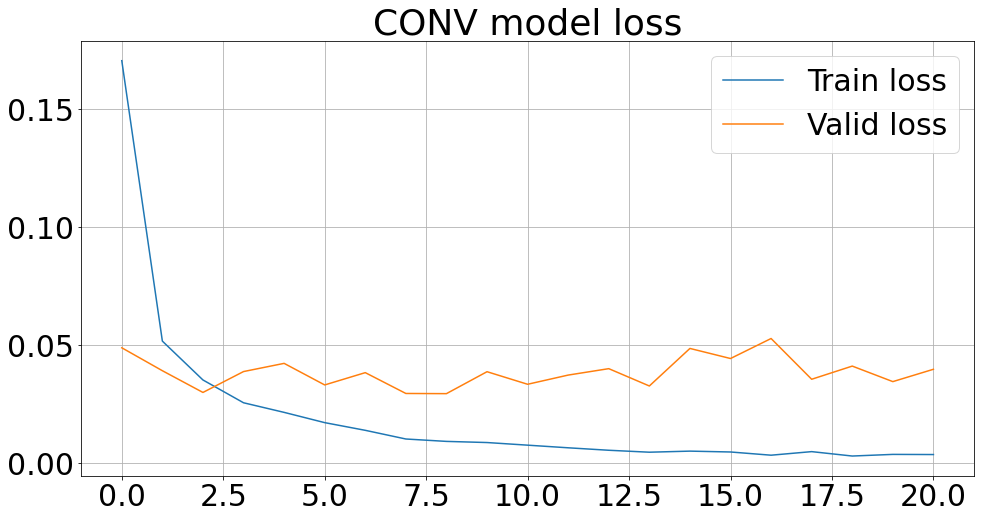

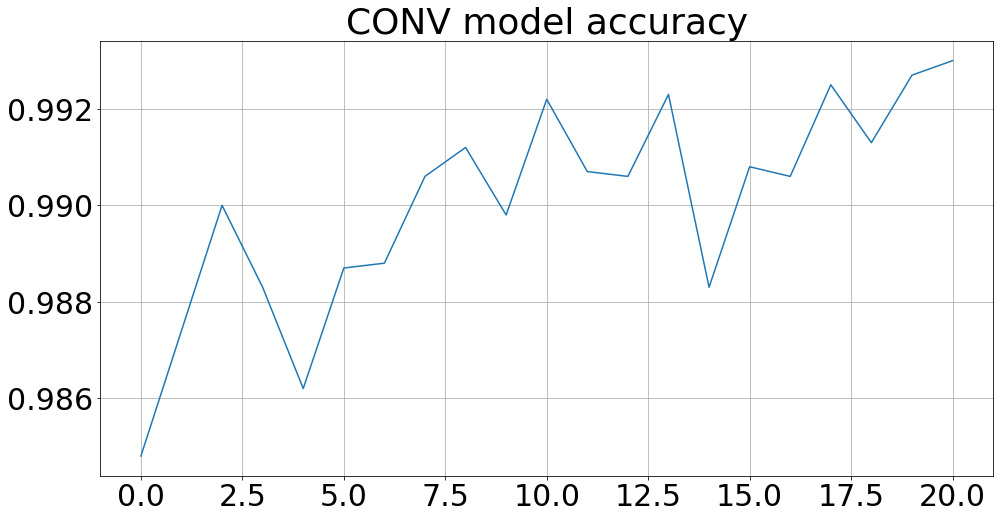

epoch = 20 | accuracy = 0.993
Total training and evaluation time 673.09370
Accuracy on test = 0.993


In [32]:
num_epochs = 100
treshhold = 0.993


train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

start = perf_counter()

for epoch in range(num_epochs):
    train_loss = train(second_model)

    valid_loss, valid_accuracy = evaluate(second_model, valid_loader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)

    clear_output()

    plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'CONV model')
    print(f"epoch = {epoch} | accuracy = {valid_accuracy}")
    if valid_accuracy >= treshhold:
        break
print(f'Total training and evaluation time {perf_counter() - start:.5f}')
print(f"Accuracy on test = {valid_accuracy_history[-1]}")

In [ ]:
valid_accuracy_history

In [ ]:
"""
Обучите полносвязную нейронную сеть для классификации на датасете MNIST. 
Добейтесь качества в 98% на тестовой выборке.

Можете использовать уже написанные ранее функции train и evaluate.

Чтобы мы могли проверить вашу модель, напишите функцию, которая создает вашу модель и возвращает объект, 
назовите функцию create_mlp_model, без аргументов. 
Вам понадобится сохранить веса вашей модели и сдать их в тестировщик, для этого воспользуйтесь методами torch.save и state_dict.
"""

def create_mpl_model():
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )
    return model

In [52]:
torch.save(second_model.state_dict(), "checkpoint.pth")